In [2]:
import keras
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook
import zipfile
##=====================================================
import tensorflow  as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D,Reshape, Dropout, Dense, GlobalAveragePooling2D, \
BatchNormalization, Input, Flatten, MaxPooling2D, UpSampling2D,Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adadelta, SGD, Adam
from keras.utils import to_categorical
import keras.backend as K

tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)

Using TensorFlow backend.


In [0]:
data = zipfile.ZipFile(('shuffled-dataset.zip'), 'r')
data.extractall()

In [7]:
csv_data = pd.read_csv('15features.csv')
display(csv_data.head()), display(csv_data.shape)
train_path = 'seen-dataset/TrainingSet/'
train_images = os.listdir(train_path)

val_path = 'seen-dataset/ValidationSet/'
val_images = os.listdir(val_path)
len(train_images)+len(val_images)
print(csv_data.dtypes)

,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0968c_num1.png,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,0809c_num2.png,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,0237b_num6.png,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,0069b_num2.png,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,0966c_num4.png,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2


(13570, 16)

imagename         object
pen_pressure       int64
letter_spacing     int64
size               int64
dimension          int64
is_lowercase       int64
is_continuous      int64
slantness          int64
tilt               int64
entry_stroke_a     int64
staff_of_a         int64
formation_n        int64
staff_of_d         int64
exit_stroke_d      int64
word_formation     int64
constancy          int64
dtype: object


In [8]:
## converting the object type to string in the dataframe 
dataset_columns = csv_data.columns
csv_data['imagename'] = csv_data['imagename'].astype('str')
display(csv_data.head(20))
csv_data.shape

,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0968c_num1.png,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,0809c_num2.png,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,0237b_num6.png,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,0069b_num2.png,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,0966c_num4.png,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2
5,1316a_num2.png,2,2,1,1,2,2,3,1,1,2,2,2,3,2,2
6,1503c_num2.png,2,1,2,2,2,2,2,1,1,3,2,2,3,2,2
7,0113c_num1.png,2,3,2,2,2,1,2,1,1,1,2,2,2,2,2
8,0221a_num6.png,2,2,2,2,2,1,1,1,1,4,1,2,3,1,2
9,0068a_num4.png,1,1,2,2,2,2,1,1,1,2,2,2,2,2,2


(13570, 16)

In [9]:
dataset_columns = csv_data.columns
f = []
for col in dataset_columns[1:]:
    f.append(csv_data[col].unique().shape[0])
f,len(f)

([2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2], 15)

In [10]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)


Instructions for updating:
Colocations handled automatically by placer.


In [11]:
encoder = Model(autoencoder.input,autoencoder.get_layer('encoded').output)
encoder.summary()
dense_layer = encoder.get_layer('encoded').output
out_dense_layer=[]
for i in range(1,len(f)+1):
    out_dense_layer.append(Dense(f[i-1] , activation='softmax', name = 'out_feature_'+str(i))(Dense(128 , activation='relu', name = 'dense_layer_'+str(i))(Flatten(name='flatten_'+str(i))((dense_layer)))))

human_features = Model(inputs=encoder.input, outputs=out_dense_layer)
human_features.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [0]:
def datagen(batch_size,image_path,list_of_writers,lengths,vshift = (-64,64) ,vis=False):
    counter = 0
    w_ids,ids,x,y,imagenames, feature_list = [],[],[],[],[],[]
    feature_lengths =lengths
    while True:

        
        writer_index = np.random.randint(0,len(list_of_writers))
        

        imagename = list_of_writers[writer_index]

        features = csv_data[csv_data['imagename']==imagename].values
        if len(features)==0:

            continue
        features = features[0][1:]-1



        loaded_image = cv2.imread(os.path.join(image_path,imagename),0)
        rand = np.random.randint(vshift[0],vshift[1])
        loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)

        x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
        y.append(255.0-loaded_image.reshape((64,64,1)))
        w_ids.append(imagename[:4])
        imagenames.append(imagename)
        ids.append(writer_index)
        feature_list.append(features)

        counter+=1

        if counter == batch_size:
            counter=0
            feature_list = np.array(feature_list)
            feature_list = feature_list.transpose()
            out_cat_features = []
            for i in range(len(feature_list)):

                out_cat_features.append(to_categorical(feature_list[i],num_classes=feature_lengths[i]))
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(imagenames)]
            else:
                yield np.array(x)/255.0,out_cat_features
            w_ids,ids,x,y,imagenames,feature_list =[], [],[], [],[],[]
            
            
 ## === Function 2 =====
def latent_Features(testx,testy):
  feature_wise_pred_y=human_features_eval.predict(testx)
  latent_pred_y=human_features_encoder.predict(testx)
  feature_wise_pred_y=np.array(feature_wise_pred_y)
  latent_pred_y=np.array(latent_pred_y).reshape((-1,512))
  ids = testy[0].reshape(-1,1)
  imagenames = testy[1].reshape(-1,1)
  data=[]
  for i in range(len(testx)):
      data.append([ids[i][0],imagenames[i][0],latent_pred_y[i]])
  df_data = pd.DataFrame(data=data, columns=['identity','imagename','latent'])
  df_data=df_data.sort_values(by='identity').reset_index()
  df_data.head(10)
  return df_data
  
def cross_validation(df_data):
  cos_dist_out = cosine_similarity(list(df_data['latent'].values))
  queried_count, idx_count, tp, tn, fp, fn = 0,0,0,0,0,0
  cos_thresh = 0.8
  data_result = []
  fp_list = []
  fn_list = []
  r_counter = 0
  stop_at = 20
  prev_query = ''
  prev_given = ''
  given_count = 0
  
  for row in tqdm_notebook(cos_dist_out):
      c_counter = 0
      given_idx = df_data.iloc[r_counter]['identity']
      given_img = df_data.iloc[r_counter]['imagename']
      for col in row:
          queried_idx = df_data.iloc[c_counter]['identity']
          queried_img = df_data.iloc[c_counter]['imagename']
          if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
              tp += 1
          if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
              tn += 1
          if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
              fp += 1
              fp_list.append(os.path.join(queried_idx,queried_img))
          if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
              fn += 1
              fn_list.append(os.path.join(queried_idx,queried_img))
          if int(given_idx) == int(queried_idx):
              idx_count += 1
          if prev_query != queried_idx:
  
              queried_count += 1
          c_counter += 1
          prev_query = queried_idx
      precision = tp/(fp+tp)
      recall = tp/(tp+fn)
      f1 = 2*(precision*recall)/(precision+recall)
      total = np.sum((tp,tn,fp,fn))
      accuracy = (tp+tn)/total
      data_result.append([given_idx,given_img, idx_count, tp, tn, fp, fn,precision,recall,f1,accuracy, total, fp_list, fn_list])
      if prev_given != given_idx:
  
          given_count+=1
      r_counter += 1
      prev_given = given_idx
      queried_count, idx_count, tp, tn, fp, fn = 0, 0, 0, 0, 0, 0
      fp_list = []
      fn_list = []
  df_cos_dist_out = pd.DataFrame(data_result, columns=['identity','imagename','total_images_identity','TP','TN','FP','FN','precision','recall','f1','accuracy','total_images', 'FP_List','FN_List'])
  df_cos_dist_out=df_cos_dist_out.sort_values(by='identity',ascending=True).reset_index().drop(columns=['index'])
  
  return df_cos_dist_out 
  

In [13]:
batch_size = 64
feature_lengths = {}

print(dataset_columns[1:])
for col in (dataset_columns[1:]):
  feature_lengths[col] = len(csv_data[col].unique())
  
feature_lengths = list(feature_lengths.values())

tg = datagen(batch_size,image_path=train_path,lengths = feature_lengths,vshift=(-10,10),list_of_writers=train_images)
vg = datagen(batch_size,image_path=val_path,lengths = feature_lengths,vshift=(-10,10), list_of_writers=val_images)

Index(['pen_pressure', 'letter_spacing', 'size', 'dimension', 'is_lowercase',
       'is_continuous', 'slantness', 'tilt', 'entry_stroke_a', 'staff_of_a',
       'formation_n', 'staff_of_d', 'exit_stroke_d', 'word_formation',
       'constancy'],
      dtype='object')


In [14]:
len(csv_data['letter_spacing'].unique())

3

(64, 64, 64, 1)


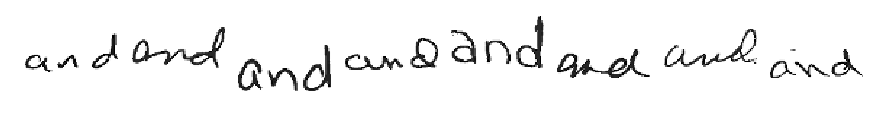

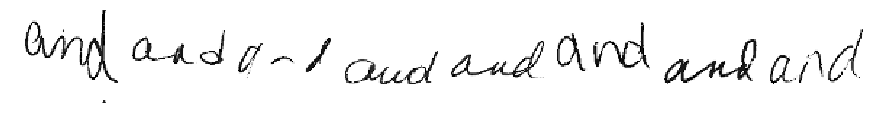

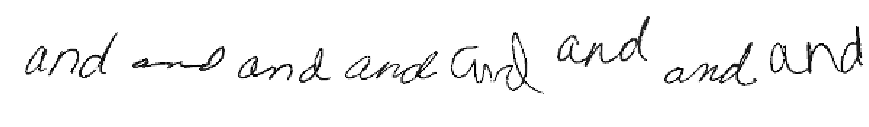

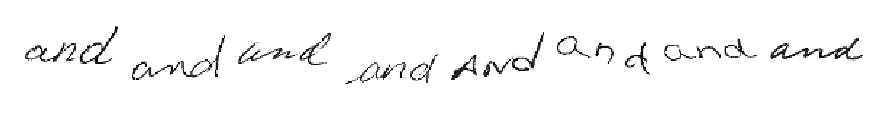

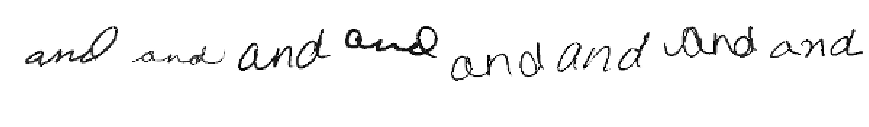

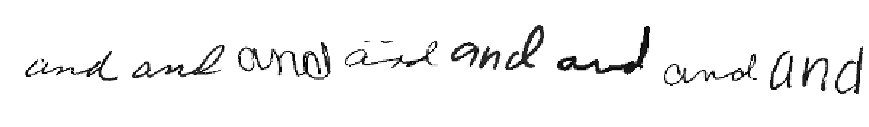

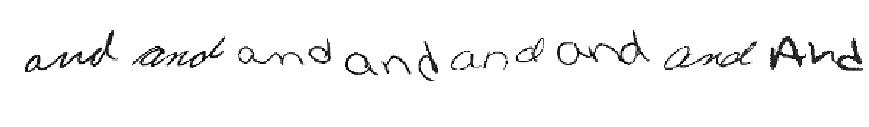

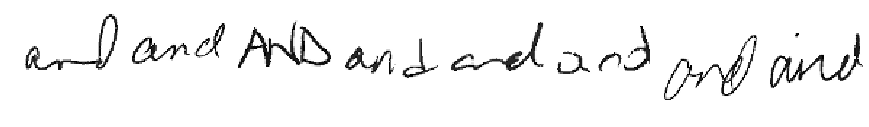

In [15]:
inputs,o = next(tg)
print(inputs.shape)
for r in range(8):
    f,ax = plt.subplots(1,8)
    f.subplots_adjust(hspace = .00, wspace=.15)
    f.set_size_inches(15,5)
    for c in range (8):
        ax[c].imshow(inputs[c+r*8].reshape((64,64)))
        ax[c].axis('off')

In [0]:
losses = {}
lossWeights = {}
for i in range(1,16):
    losses["out_feature_"+str(i)] = "categorical_crossentropy"
    lossWeights["out_feature_"+str(i)] = 1.0

In [0]:
mc = ModelCheckpoint(filepath='15-Multitask-TrainableEncoder-seen_v2.h5', monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=1000, monitor='val_loss', min_delta=0.0005, mode='auto')

In [18]:

EPOCHS = 1000
INIT_LR = 0.0001
opt = SGD(lr=INIT_LR, decay=1e-6, momentum=0.95, nesterov=True)
#human_features.load_weights('15-Multitask-TrainableEncoder-seen_v2.h5')
human_features.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [23]:
hist = human_features.fit_generator(tg, callbacks=[mc,es]
                                    , epochs=EPOCHS
                                    , steps_per_epoch = 1
                                    , validation_data = vg
                                    , validation_steps = 1
                                    , verbose = 3)

Epoch 1/1000

Epoch 00001: val_loss did not improve from 8.27480
Epoch 2/1000

Epoch 00002: val_loss did not improve from 8.27480
Epoch 3/1000

Epoch 00003: val_loss did not improve from 8.27480
Epoch 4/1000

Epoch 00004: val_loss did not improve from 8.27480
Epoch 5/1000

Epoch 00005: val_loss did not improve from 8.27480
Epoch 6/1000

Epoch 00006: val_loss did not improve from 8.27480
Epoch 7/1000

Epoch 00007: val_loss did not improve from 8.27480
Epoch 8/1000

Epoch 00008: val_loss did not improve from 8.27480
Epoch 9/1000

Epoch 00009: val_loss did not improve from 8.27480
Epoch 10/1000

Epoch 00010: val_loss did not improve from 8.27480
Epoch 11/1000

Epoch 00011: val_loss did not improve from 8.27480
Epoch 12/1000

Epoch 00012: val_loss did not improve from 8.27480
Epoch 13/1000

Epoch 00013: val_loss did not improve from 8.27480
Epoch 14/1000

Epoch 00014: val_loss did not improve from 8.27480
Epoch 15/1000

Epoch 00015: val_loss did not improve from 8.27480
Epoch 16/1000

Epoc

7.701369285583496


,loss,out_feature_10_acc,out_feature_10_loss,out_feature_11_acc,out_feature_11_loss,out_feature_12_acc,out_feature_12_loss,out_feature_13_acc,out_feature_13_loss,out_feature_14_acc,...,val_out_feature_5_acc,val_out_feature_5_loss,val_out_feature_6_acc,val_out_feature_6_loss,val_out_feature_7_acc,val_out_feature_7_loss,val_out_feature_8_acc,val_out_feature_8_loss,val_out_feature_9_acc,val_out_feature_9_loss


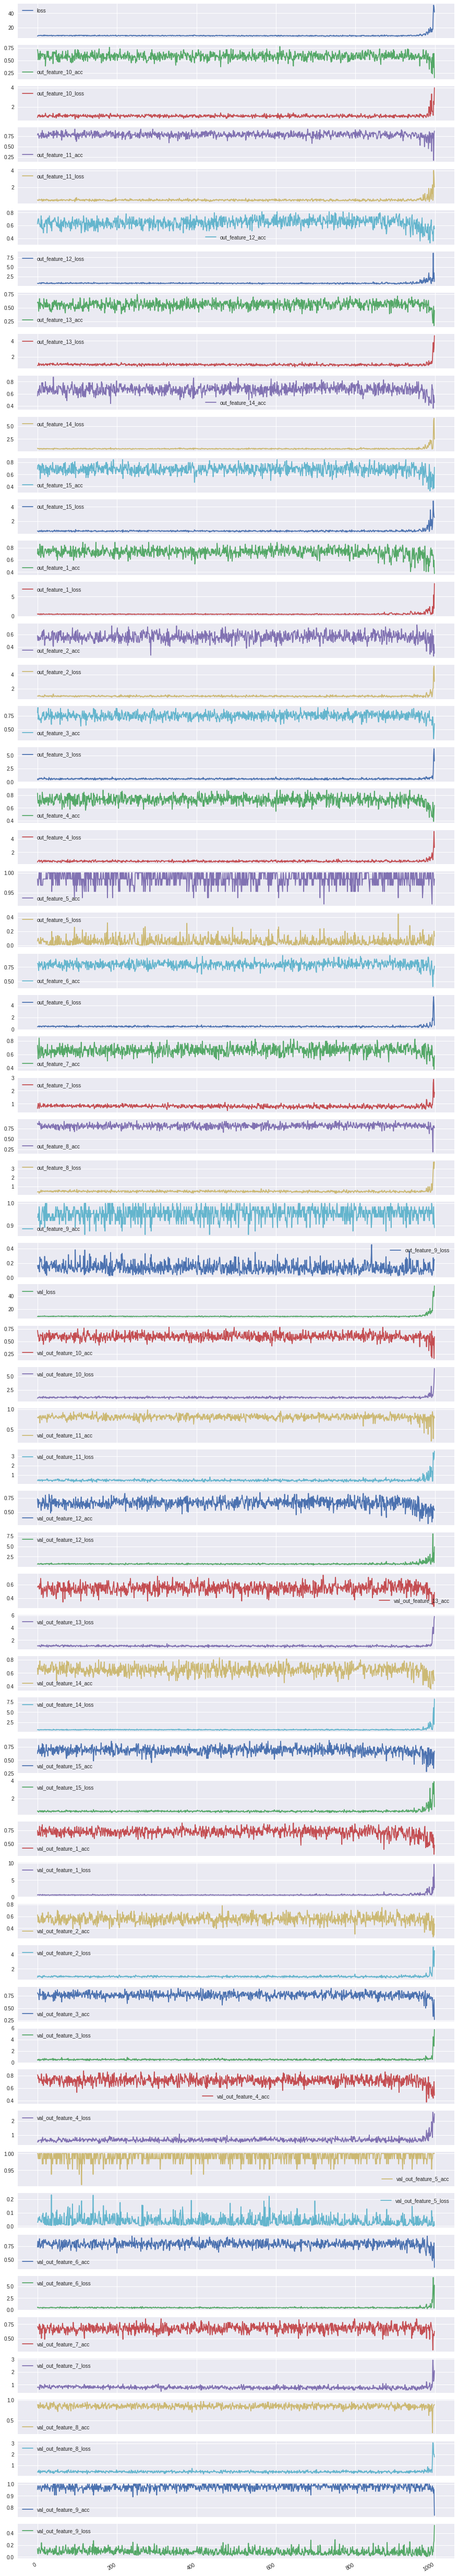

In [24]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,100))
print(df_hist['val_loss'].min())
df_hist[df_hist['val_loss']<5.93] ## why only 5.93 ?? how

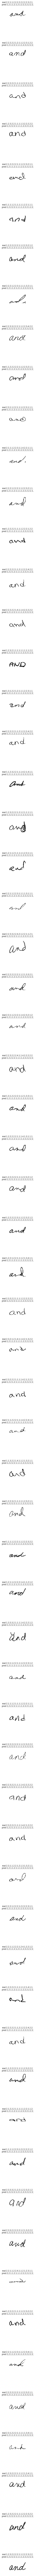

In [26]:

vx,vo=next(vg)
# print(len(vo))
fig = plt.figure(figsize=(80,200))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=1.51, wspace=0.05)
for i in range(64):
    real=''
    for f in range(15):

        real+=str(np.argmax(vo[f][i])+1)+','
    
    f_probs = human_features.predict(np.expand_dims(vx[i],0))

    pred=''
    for prob in f_probs:

        pred+=str(np.argmax(prob[0])+1)+','
    
    ax = fig.add_subplot(64, 1, i + 1, xticks=[], yticks=[])
    ax.imshow(vx[i].reshape((64,64)))
    ax.set_title('real:'+real+'\n pred:'+pred)


In [0]:
pred_flat = []
for i in range(1,len(feature_lengths)+1):
    pred_flat.append(human_features.get_layer('dense_layer_'+str(i)).output)
human_features_eval = Model(inputs=human_features.input, outputs=pred_flat)
human_features_encoder = Model(human_features.input,human_features.get_layer('encoded').output)

In [0]:
test_g = datagen(len(val_images),val_path,val_images,lengths = feature_lengths ,vshift = (-10,10), vis=True)
testx_s,testy_s = next(test_g)


In [39]:
Seen_latent = latent_Features(testx_s,testy_s)
display(Seen_latent.head(10))


,index,identity,imagename,latent
0,22,0001,0001a_num2.png,"[13.818772, 0.0, 25.41305, 0.0, 0.0, 3.3497326..."
1,161,0002,0002a_num2.png,"[11.473217, 0.0, 20.20393, 0.0, 0.0, 1.8546287..."
2,625,0002,0002a_num1.png,"[10.733434, 0.0, 18.223873, 0.0, 0.0, 1.179225..."
3,630,0005,0005a_num1.png,"[9.232995, 0.0, 20.3477, 0.0, 0.0, 3.3560019, ..."
4,795,0006,0006a_num1.png,"[12.901208, 0.0, 25.22064, 0.0, 0.0, 4.1413903..."
5,844,0006,0006a_num2.png,"[12.224872, 0.0, 24.489365, 0.0, 0.0, 4.413942..."
6,681,0006,0006a_num1.png,"[13.039158, 0.0, 25.203001, 0.0, 0.0, 4.448222..."
7,464,0006,0006a_num1.png,"[13.191911, 0.0, 23.617085, 0.0, 0.0, 4.104798..."
8,170,0006,0006a_num2.png,"[12.994153, 0.0, 25.04888, 0.0, 0.0, 4.5826907..."
9,34,0006,0006a_num2.png,"[12.2451935, 0.0, 23.754332, 0.0, 0.0, 4.10867..."


In [42]:
Seen_cv_df = cross_validation(Seen_latent)

In [66]:
seen_total = Seen_cv_df.shape[0]
seen_total_images = Seen_cv_df['total_images_identity']
s_tps = Seen_cv_df['TP'].sum()
s_fps = Seen_cv_df['FP'].sum()
s_tns = Seen_cv_df['TN'].sum()
s_fns = Seen_cv_df['FN'].sum()
s_precision = s_tps/(s_fps+s_tps)
s_recall = s_tps/(s_tps+s_fns)
s_f1 = 2*(s_precision*s_recall)/(s_precision+s_recall)
print('precision:',s_precision,'\nrecall:',s_recall,'\nf1:',s_f1)
s_acc = Seen_cv_df['accuracy'].mean()
print('Intra Writer Accuracy (Type 1):',np.mean(Seen_cv_df['TP']/seen_total_images) )
print('Inter Writer Accuracy (Type 2)::',s_tns/seen_total/seen_total)
print('acc:',s_acc)

precision: 0.03204222865616835 
recall: 0.8 
f1: 0.06387977228532965
Intra Writer Accuracy (Type 1): 0.7667957771343832
Inter Writer Accuracy (Type 2):: 0.806387977228533
acc: 0.8204222865616824


In [0]:
## ==== For unseeen Dataset ======
un_val_path = 'unseen-dataset/ValidationSet/'
un_v_img = os.listdir(un_val_path)
len(un_v_img)
un_val_list_of_writers = un_v_img
test_Unseen = datagen(len(un_val_list_of_writers),un_val_path,un_val_list_of_writers,lengths = feature_lengths, vshift = (-12,12), vis=True)
vx_us,vy_us = next(test_Unseen)

In [0]:
Unseen_latent = latent_Features(vx_us,vy_us)



In [57]:
Unseen_cv_df = cross_validation(Unseen_latent)

In [69]:
Unseen_total = Unseen_cv_df.shape[0]
Unseen_total_images = Unseen_cv_df['total_images_identity']
us_tps = Unseen_cv_df['TP'].sum()
us_fps = Unseen_cv_df['FP'].sum()
us_tns = Unseen_cv_df['TN'].sum()
us_fns = Unseen_cv_df['FN'].sum()
us_precision = us_tps/(us_fps+us_tps)
us_recall = us_tps/(us_tps+us_fns)
us_f1 = 2*(us_precision*us_recall)/(us_precision+us_recall)
print('precision:',us_precision,'\nrecall:',us_recall,'\nf1:',us_f1)
us_acc = Unseen_cv_df['accuracy'].mean()
print('Intra Writer Accuracy (Type 1):',np.mean(Unseen_cv_df['TP']/Unseen_total_images))
print('Inter Writer Accuracy (Type 2)::',us_tns/Unseen_total/Unseen_total)
print('acc:',us_acc)

precision: 0.11826860644428212 
recall: 0.8 
f1: 0.23377241906576257
Intra Writer Accuracy (Type 1): 0.8817313935557178
Inter Writer Accuracy (Type 2):: 0.5337724190657626
acc: 0.6182686064442816


In [0]:
# ===== For Shuffled Dataset =======
sh_val_path = 'shuffled-dataset/ValidationSet/'
sh_v_img = os.listdir(sh_val_path)
len(sh_v_img)
sh_val_list_of_writers = sh_v_img
test_shuffle = datagen(len(sh_val_list_of_writers),sh_val_path,sh_val_list_of_writers,lengths = feature_lengths, vshift = (-12,12), vis=True)
vx_sh,vy_sh = next(test_shuffle)

In [0]:
shuffle_latent = latent_Features(vx_sh,vy_sh)

In [75]:
shuffle_cv_df = cross_validation(shuffle_latent)

In [80]:
shuffle_total = shuffle_cv_df.shape[0]
shuffle_total_images = shuffle_cv_df['total_images_identity']
sh_tps = shuffle_cv_df['TP'].sum()
sh_fps = shuffle_cv_df['FP'].sum()
sh_tns = shuffle_cv_df['TN'].sum()
sh_fns = shuffle_cv_df['FN'].sum()
sh_precision = sh_tps/(sh_fps+sh_tps)
sh_recall = sh_tps/(sh_tps+sh_fns)
sh_f1 = 2*(sh_precision*sh_recall)/(sh_precision+sh_recall)
print('precision:',sh_precision,'\nrecall:',sh_recall,'\nf1:',sh_f1)
sh_acc = shuffle_cv_df['accuracy'].mean()
print('Intra Writer Accuracy (Type 1):',np.mean(shuffle_cv_df['TP']/shuffle_total_images) )
print('Inter Writer Accuracy (Type 2)::',sh_tns/shuffle_total/shuffle_total)
print('acc:',sh_acc)

precision: 0.024976569182625495 
recall: 1.0 
f1: 0.049828683409405564
Intra Writer Accuracy (Type 1): 0.750234308173745
Inter Writer Accuracy (Type 2):: 0.44982868340940557
acc: 0.6249765691826255
